<a href="https://colab.research.google.com/github/VictoorV/Mask_detection/blob/main/Mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

100%|██████████| 398M/398M [00:18<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1


In [2]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 49.6 MB/s eta 0:00:00


# Afficher quelques images

Taille de l'image 1: (400, 300)
Taille de l'image 2: (400, 267)
Taille de l'image 3: (400, 267)
Taille de l'image 4: (259, 400)


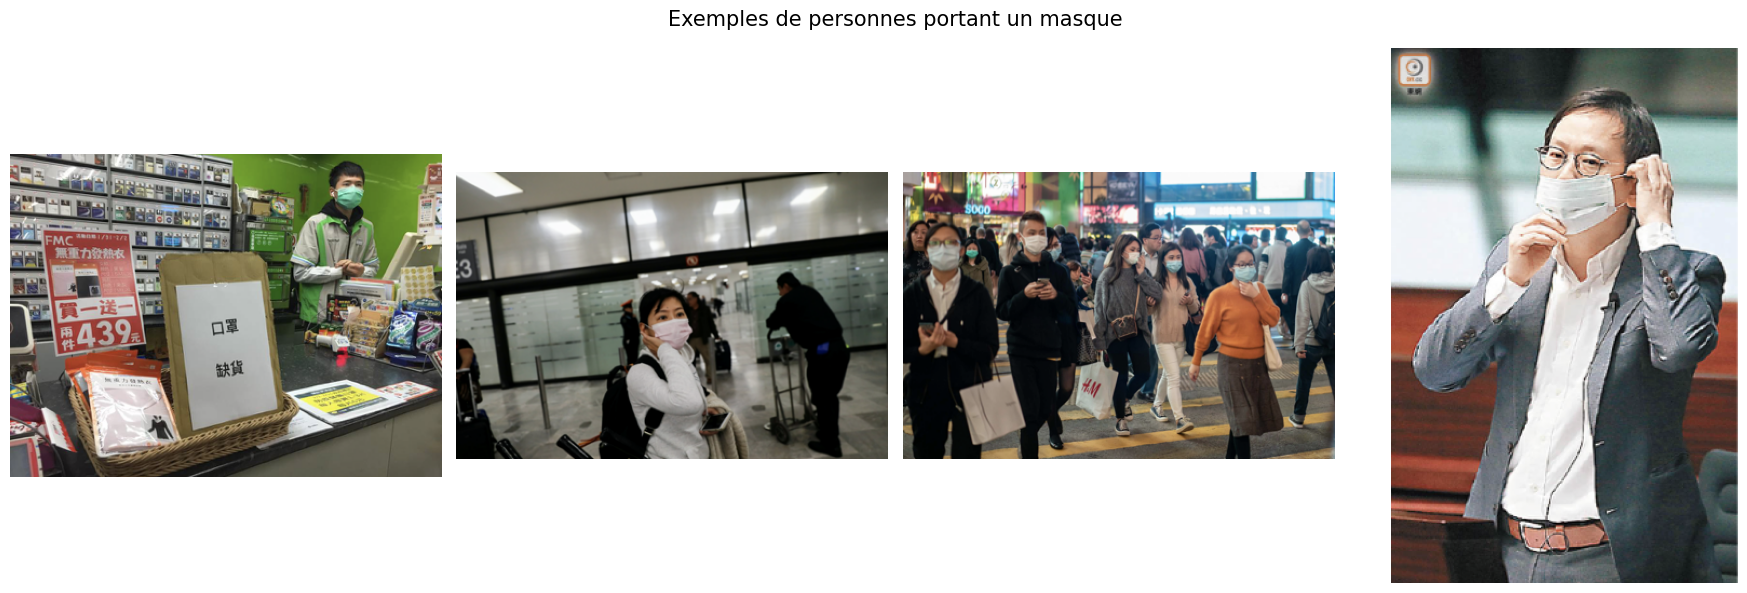

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import os

path_img = path + '/images/'
fig, axes = plt.subplots(1, 4, figsize=(18, 6))
for i in range(0,4):
    sample_image_path = os.path.join(path_img, os.listdir(path_img)[i])
    sample_image_path
    image = Image.open(sample_image_path)
    axes[i].imshow(image)
    axes[i].axis("off")
    print(f"Taille de l'image {i+1}:", image.size)
fig.suptitle(f"Exemples de personnes portant un masque", fontsize=15)
plt.tight_layout()
plt.show()

# Extraire les données XML

In [4]:
import xml.etree.ElementTree as ET
import pandas as pd

df = {'filename': [],
     'width': [],
     'height': [],
     'label': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}

path_xml = path + '/annotations/'
elements = os.listdir(path_xml)
for element in elements:
  tree = ET.parse(path_xml + element)
  root = tree.getroot()

  for object in root.findall('object'): # Il y a peut être plusieurs objets pour un seul fichier .xml
    df['filename'].append(root[1].text)
    df['width'].append(root[2][0].text)
    df['height'].append(root[2][1].text)
    df['label'].append(object[0].text)
    df['xmin'].append(object[-1][0].text)
    df['ymin'].append(object[-1][1].text)
    df['xmax'].append(object[-1][2].text)
    df['ymax'].append(object[-1][3].text)

df = pd.DataFrame(df)
df[['width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']] = df[['width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']].apply(pd.to_numeric)

In [5]:
df

filename  width  height                  label  xmin  ymin  \
0     maksssksksss599.png    301     400              with_mask    86   144   
1     maksssksksss571.png    301     400           without_mask   122   196   
2     maksssksksss601.png    301     400              with_mask    84   163   
3     maksssksksss391.png    400     270              with_mask    93    34   
4     maksssksksss391.png    400     270              with_mask   174    62   
...                   ...    ...     ...                    ...   ...   ...   
4067  maksssksksss333.png    301     400              with_mask    76   203   
4068   maksssksksss29.png    400     295              with_mask    50    96   
4069   maksssksksss29.png    400     295  mask_weared_incorrect   223    81   
4070   maksssksksss29.png    400     295  mask_weared_incorrect   279    44   
4071  maksssksksss748.png    400     225  mask_weared_incorrect   179    47   

      xmax  ymax  
0      198   281  
1      210   319  
2      184   300  
3      119    61  
4      199    92  
...    ...   ...  
4067   181   330  
4068   120   171  
4069   285   159  
4070   340   114  
4071   283   169  

[4072 rows x 8 columns]

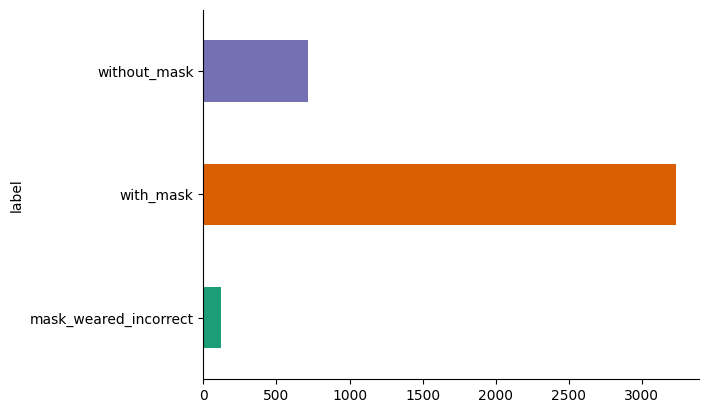

In [6]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
df['label'] = df['label'].replace({'without_mask' : 0,
                    'with_mask' : 1,
                    'mask_weared_incorrect' : 2})

<ipython-input-7-d8844236e260>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace({'without_mask' : 0,


Taille de l'image: (512, 366)


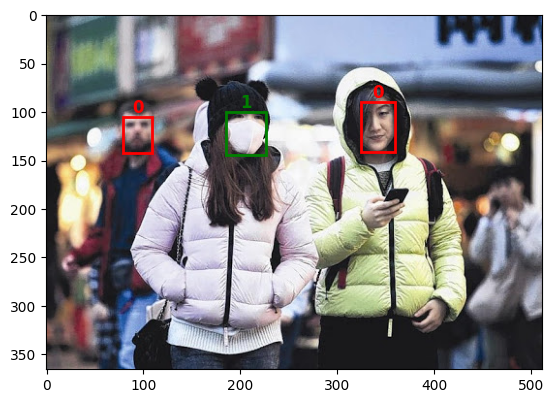

In [8]:
import os
from PIL import Image
from matplotlib.patches import Rectangle

img = 'maksssksksss0.png'
sample_image_path = os.path.join(path_img, img)
image = Image.open(sample_image_path)

class_colors = {
    0: 'red',
    1: 'green',
    2: 'yellow'
}

fig, ax = plt.subplots()
ax.imshow(image)

for index, row in df[df['filename'] == img].iterrows():
    xmin, ymin, xmax, ymax, label = row['xmin'], row['ymin'], row['xmax'], row['ymax'], row['label']

    color = class_colors.get(label, 'black')  # Si la classe n'est pas dans le dictionnaire, utilise 'black'

    rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

    ax.text((xmin + xmax) / 2, ymin - 10, label, color=color, fontsize=12, weight='bold', ha='center', va='center')

print(f"Taille de l'image:", image.size)

plt.show()

## Train_set et val_set

In [9]:
from sklearn.model_selection import train_test_split

filenames = df['filename'].unique()
filenames_train, filenames_val = train_test_split(filenames, test_size=0.1, random_state=2024)
print(f"Nombre d'images dans le train_set: {len(filenames_train)}")
print(f"Nombre d'images dans le val_set: {len(filenames_val)}")

Nombre d'images dans le train_set: 767
Nombre d'images dans le val_set: 86


In [10]:
df_train = df[df['filename'].isin(filenames_train)].copy()
df_train

filename  width  height  label  xmin  ymin  xmax  ymax
0     maksssksksss599.png    301     400      1    86   144   198   281
1     maksssksksss571.png    301     400      0   122   196   210   319
2     maksssksksss601.png    301     400      1    84   163   184   300
3     maksssksksss391.png    400     270      1    93    34   119    61
4     maksssksksss391.png    400     270      1   174    62   199    92
...                   ...    ...     ...    ...   ...   ...   ...   ...
4067  maksssksksss333.png    301     400      1    76   203   181   330
4068   maksssksksss29.png    400     295      1    50    96   120   171
4069   maksssksksss29.png    400     295      2   223    81   285   159
4070   maksssksksss29.png    400     295      2   279    44   340   114
4071  maksssksksss748.png    400     225      2   179    47   283   169

[3787 rows x 8 columns]

In [11]:
df_val = df[df['filename'].isin(filenames_val)].copy()
df_val

filename  width  height  label  xmin  ymin  xmax  ymax
56    maksssksksss530.png    301     400      0    76   236   149   349
81    maksssksksss313.png    400     400      1   143    39   309   257
206   maksssksksss151.png    400     200      0    59   131    64   138
207   maksssksksss151.png    400     200      1    82   127    89   134
208   maksssksksss151.png    400     200      1   101   142   105   146
...                   ...    ...     ...    ...   ...   ...   ...   ...
4030  maksssksksss728.png    400     266      1   104    45   120    63
4031  maksssksksss728.png    400     266      1   188    60   202    73
4032  maksssksksss728.png    400     266      1   263    84   278   102
4033  maksssksksss728.png    400     266      2   349    71   363    86
4034  maksssksksss728.png    400     266      1   381    82   395   100

[285 rows x 8 columns]

# Mise au format YOLO

## Création des dossiers train/val et des fichiers .txt



```
dataset/
├── train/
│   ├── images/
│   │   ├── img1.jpg
│   │   ├── img2.jpg
│   ├── labels/
│       ├── img1.txt
│       ├── img2.txt
├── val/
│   ├── images/
│   ├── labels/
```



In [12]:
base_path = "/content/dataset"
train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")

os.makedirs(os.path.join(train_path, "images"), exist_ok=True)
os.makedirs(os.path.join(train_path, "labels"), exist_ok=True)
os.makedirs(os.path.join(val_path, "images"), exist_ok=True)
os.makedirs(os.path.join(val_path, "labels"), exist_ok=True)

In [13]:
import shutil

def copy_images(df, source_folder, target_folder):
    for filename in df['filename'].unique():
        source_path = os.path.join(source_folder, filename)
        target_path = os.path.join(target_folder, "images", filename)
        shutil.copy(source_path, target_path)

source_images_folder = path_img
copy_images(df_train, source_images_folder, train_path)
copy_images(df_val, source_images_folder, val_path)

In [14]:
def generate_labels(df, target_folder):

    for filename in df['filename'].unique():
        label_path = os.path.join(target_folder, "labels", filename.replace('.png', '.txt'))

        with open(label_path, 'w') as f:
            # Pour chaque ligne correspondant au filename (un ou plusieurs objets)
            for _, row in df[df['filename'] == filename].iterrows():
                # Calcul des coordonnées normalisées
                x_center = (row['xmin'] + row['xmax']) / 2 / row['width']
                y_center = (row['ymin'] + row['ymax']) / 2 / row['height']
                width = (row['xmax'] - row['xmin']) / row['width']
                height = (row['ymax'] - row['ymin']) / row['height']

                f.write(f"{row['label']} {x_center} {y_center} {width} {height}\n")

generate_labels(df_train, train_path)
generate_labels(df_val, val_path)

## Création des fichiers .yaml

In [15]:
yaml_path = "/content/data.yaml"

yaml_content = """
train: /content/dataset/train/images
val: /content/dataset/val/images

nc: 3
names: ['without_mask', 'with_mask', 'mask_weared_incorrect']
"""

with open(yaml_path, "w") as f:
    f.write(yaml_content)

print(f"Fichier data.yaml créé à : {yaml_path}")

Fichier data.yaml créé à : /content/data.yaml


# Entrainement

In [16]:
from ultralytics import YOLO
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = YOLO("yolov8m.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 49.7M/49.7M [00:00<00:00, 401MB/s]


In [17]:
model.train(data="data.yaml", epochs=50, batch=32, imgsz=640, device = device)

Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

100%|██████████| 755k/755k [00:00<00:00, 123MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 139MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/train/labels... 767 images, 0 backgrounds, 0 corrupt: 100%|██████████| 767/767 [00:01<00:00, 723.56it/s]

train: New cache created: /content/dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/dataset/val/labels... 86 images, 0 backgrounds, 0 corrupt: 100%|██████████| 86/86 [00:00<00:00, 244.36it/s]

val: New cache created: /content/dataset/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      13.5G      1.763      2.618      1.525        252        640: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]

                   all         86        285      0.348      0.571      0.414      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      12.9G      1.201     0.9142      1.075        273        640: 100%|██████████| 24/24 [00:29<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         86        285      0.225      0.363      0.261      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50        14G      1.211     0.8513      1.089        301        640: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]

                   all         86        285      0.319      0.533      0.427      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      13.6G      1.163     0.7703      1.069        241        640: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         86        285     0.0296      0.381     0.0258     0.0148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      14.1G      1.194     0.7863      1.099        301        640: 100%|██████████| 24/24 [00:27<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all         86        285      0.385       0.36      0.413      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      14.1G      1.187     0.7636      1.069        268        640: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]

                   all         86        285      0.551      0.385      0.537      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      13.6G      1.165     0.7373      1.067        311        640: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         86        285      0.624      0.546      0.582      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      13.5G      1.116     0.6752      1.052        230        640: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all         86        285      0.696      0.596      0.615      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      14.2G      1.121      0.663      1.065        251        640: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all         86        285      0.781      0.746      0.707      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      13.1G      1.118     0.6674      1.055        209        640: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         86        285      0.696      0.664      0.664      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      13.4G      1.117     0.6705      1.046        283        640: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]

                   all         86        285      0.742      0.636        0.7      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50        14G       1.09     0.6361      1.039        267        640: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         86        285      0.756      0.718      0.744      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      13.4G      1.081     0.6129      1.029        214        640: 100%|██████████| 24/24 [00:26<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]

                   all         86        285      0.615       0.59      0.618      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50        13G      1.049     0.6064      1.019        314        640: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all         86        285        0.8      0.719      0.749      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      13.6G      1.066     0.5992      1.008        204        640: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         86        285      0.692      0.707      0.709      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50        13G      1.028     0.5729      1.018        261        640: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         86        285      0.609       0.74      0.691       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      14.4G      1.043     0.5815      1.024        204        640: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]

                   all         86        285      0.759      0.675       0.68      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      13.6G       1.03     0.5648      1.019        279        640: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         86        285      0.724      0.732      0.684      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      13.6G     0.9983     0.5528      1.018        229        640: 100%|██████████| 24/24 [00:26<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all         86        285      0.776      0.801      0.769       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      13.3G      1.029     0.5576     0.9991        213        640: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]

                   all         86        285      0.708      0.697      0.672      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      13.4G     0.9994     0.5334     0.9968        252        640: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         86        285      0.606      0.658      0.679      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      13.5G     0.9856     0.5254     0.9976        304        640: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         86        285      0.676      0.646      0.666       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      13.6G     0.9847     0.5202     0.9929        176        640: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

                   all         86        285      0.689      0.641      0.677      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      13.4G     0.9858     0.5216     0.9912        329        640: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         86        285      0.722      0.707      0.769      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      13.6G     0.9662     0.5159     0.9837        226        640: 100%|██████████| 24/24 [00:26<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         86        285      0.686      0.639      0.682      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      13.6G     0.9567     0.4866     0.9862        322        640: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

                   all         86        285      0.799      0.681       0.72      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      13.6G     0.9466     0.4834     0.9792        257        640: 100%|██████████| 24/24 [00:25<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         86        285      0.769      0.714      0.717      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      13.8G     0.9517     0.4974     0.9797        173        640: 100%|██████████| 24/24 [00:26<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         86        285      0.749      0.615      0.671      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      13.3G     0.9357     0.4786     0.9785        317        640: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]

                   all         86        285      0.705      0.717      0.679      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      13.9G     0.9317     0.4713      0.964        342        640: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         86        285      0.821      0.677      0.741      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      13.6G     0.9265     0.4708     0.9628        216        640: 100%|██████████| 24/24 [00:26<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all         86        285      0.731       0.64      0.691      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      13.5G     0.9158     0.4628     0.9687        251        640: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

                   all         86        285      0.715      0.727      0.775      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      13.9G     0.8633     0.4372     0.9475        348        640: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         86        285      0.631      0.731      0.715      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      14.8G     0.8703     0.4326     0.9457        303        640: 100%|██████████| 24/24 [00:26<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]

                   all         86        285      0.683      0.645        0.7      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50        14G     0.8932     0.4404     0.9466        217        640: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         86        285      0.662      0.708       0.74      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      13.6G     0.8743      0.433     0.9438        236        640: 100%|██████████| 24/24 [00:26<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         86        285      0.639      0.733      0.712      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      13.9G     0.8645     0.4212     0.9387        194        640: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]

                   all         86        285      0.676      0.727      0.747       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      13.9G      0.833     0.4111     0.9331        165        640: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         86        285      0.718      0.719      0.723      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      13.6G      0.814      0.403     0.9316        244        640: 100%|██████████| 24/24 [00:26<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         86        285      0.699      0.823       0.78       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      13.6G     0.8353     0.4138     0.9298        237        640: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]

                   all         86        285       0.78      0.768      0.781       0.58


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      13.9G     0.8404     0.3953     0.9313        103        640: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

                   all         86        285      0.765      0.773      0.766      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      14.1G     0.8229     0.3852     0.9326         96        640: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         86        285      0.827      0.763      0.759      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50        14G     0.8138     0.3702     0.9227        199        640: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]

                   all         86        285      0.784      0.701      0.736      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      13.4G     0.8157     0.3742     0.9216        128        640: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         86        285      0.846       0.74      0.774      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      13.8G      0.785     0.3514     0.9257        120        640: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         86        285      0.829      0.763      0.805      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      13.7G     0.7791     0.3537     0.9146        159        640: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]

                   all         86        285        0.8      0.698      0.757      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      14.1G     0.7684     0.3498     0.9138        119        640: 100%|██████████| 24/24 [00:25<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         86        285      0.781      0.687      0.762      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      13.2G     0.7669     0.3441      0.903        144        640: 100%|██████████| 24/24 [00:25<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         86        285      0.723      0.828      0.798      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      13.5G     0.7668     0.3404     0.9128        136        640: 100%|██████████| 24/24 [00:25<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all         86        285      0.742      0.844       0.79       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      14.1G     0.7503     0.3319     0.9007        156        640: 100%|██████████| 24/24 [00:25<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         86        285      0.732      0.837      0.796      0.572



50 epochs completed in 0.422 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


                   all         86        285      0.829      0.763      0.805      0.583
          without_mask         26         43      0.786      0.837      0.865      0.631
             with_mask         81        236      0.953      0.951      0.981      0.725
 mask_weared_incorrect          6          6      0.747        0.5       0.57      0.394
Speed: 0.2ms preprocess, 9.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7805ba981690>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

# Évaluation

In [45]:
model = YOLO('runs/detect/train/weights/best.pt')

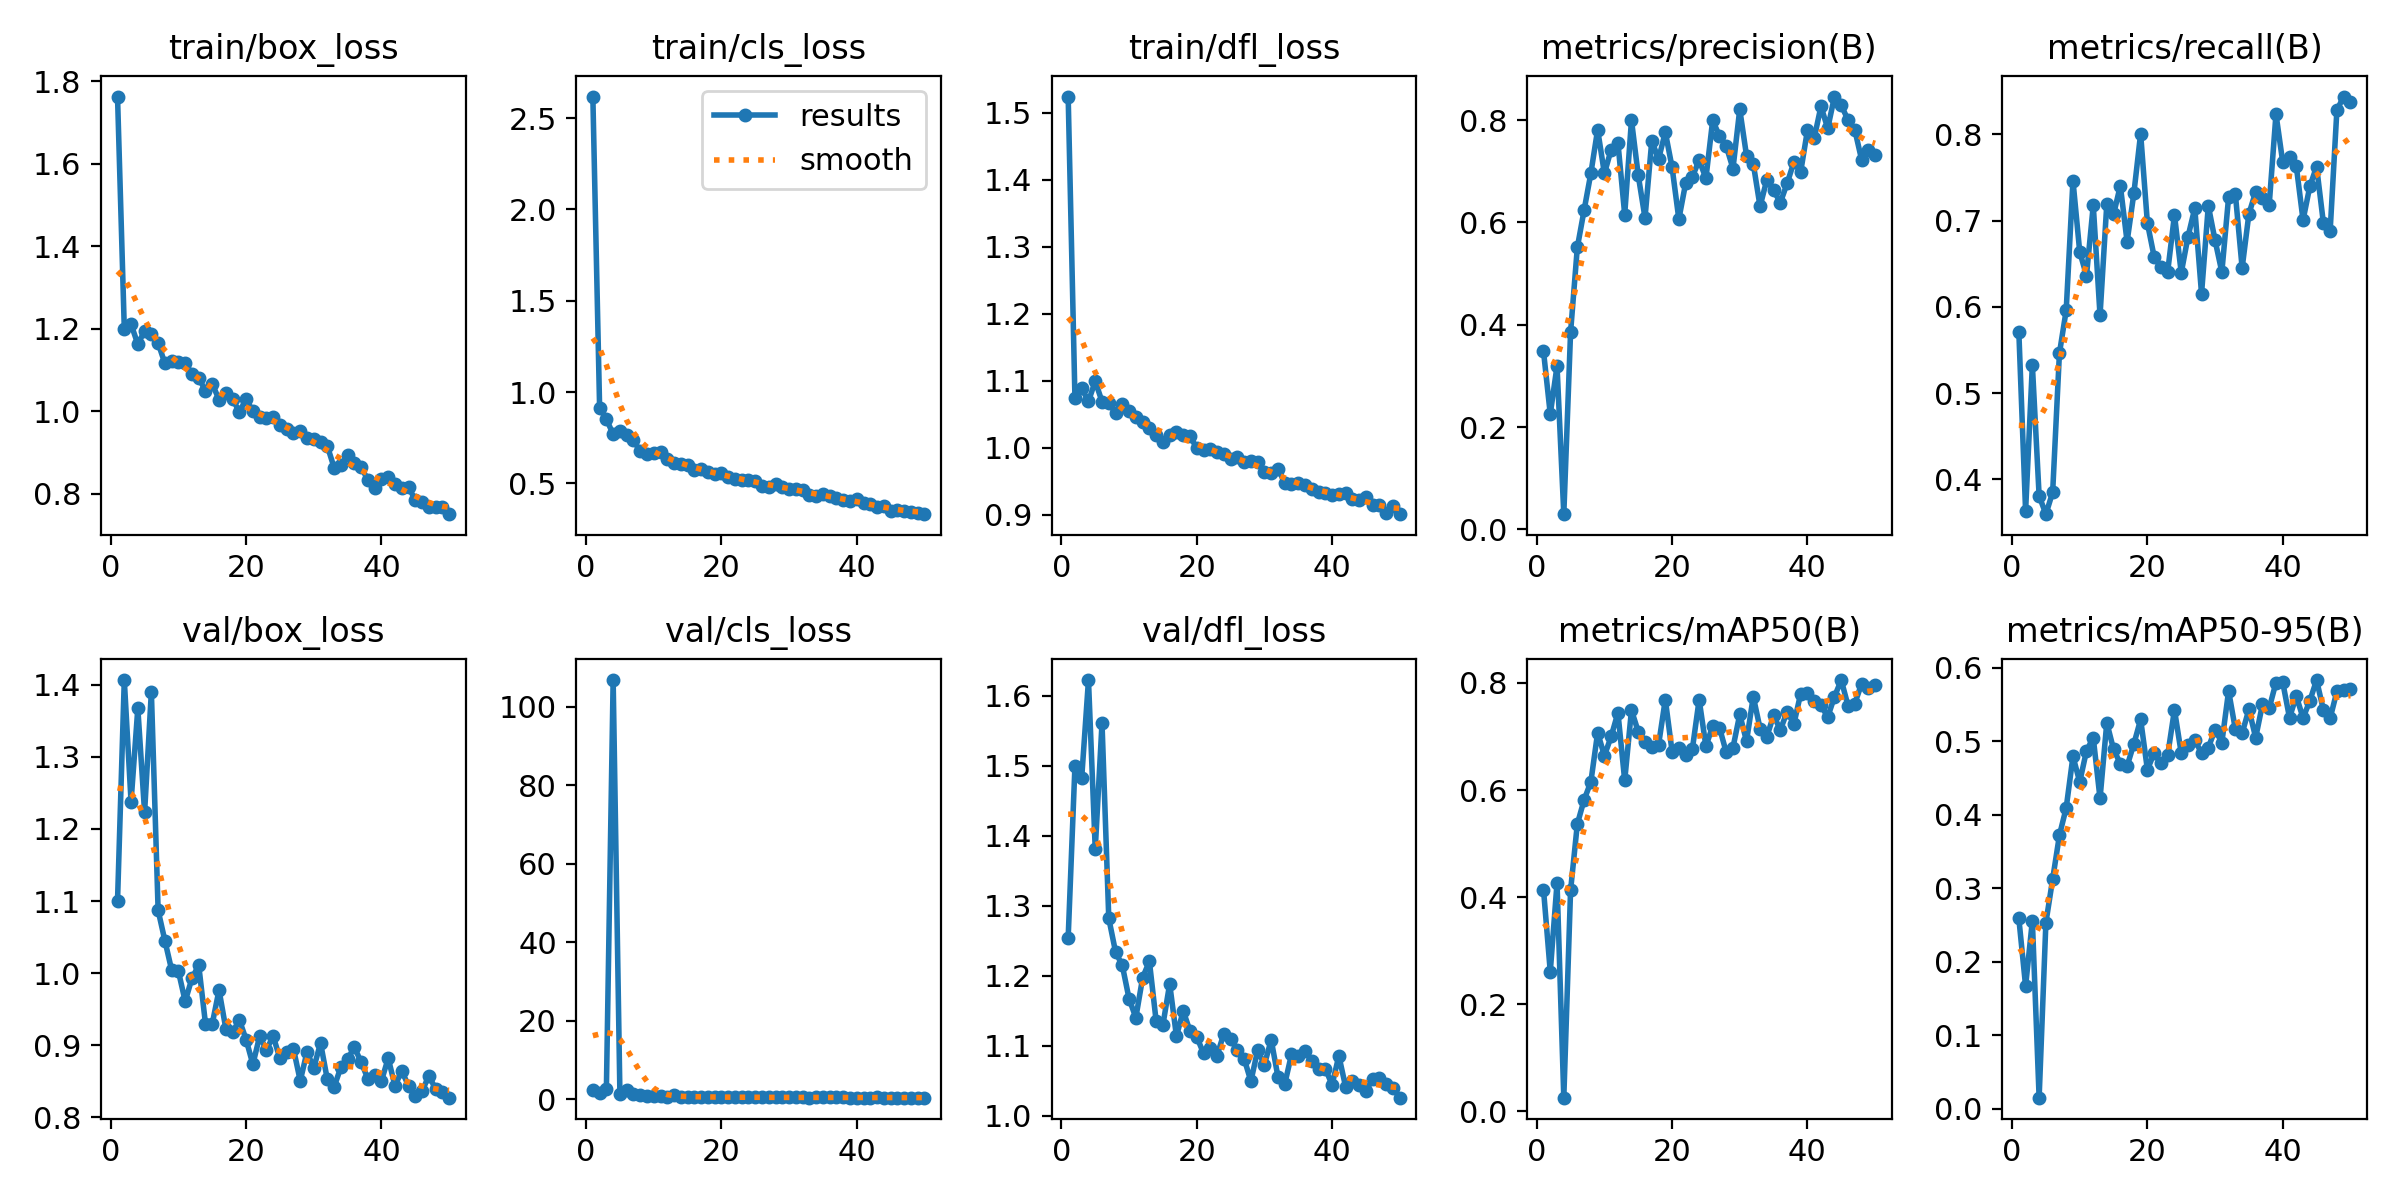

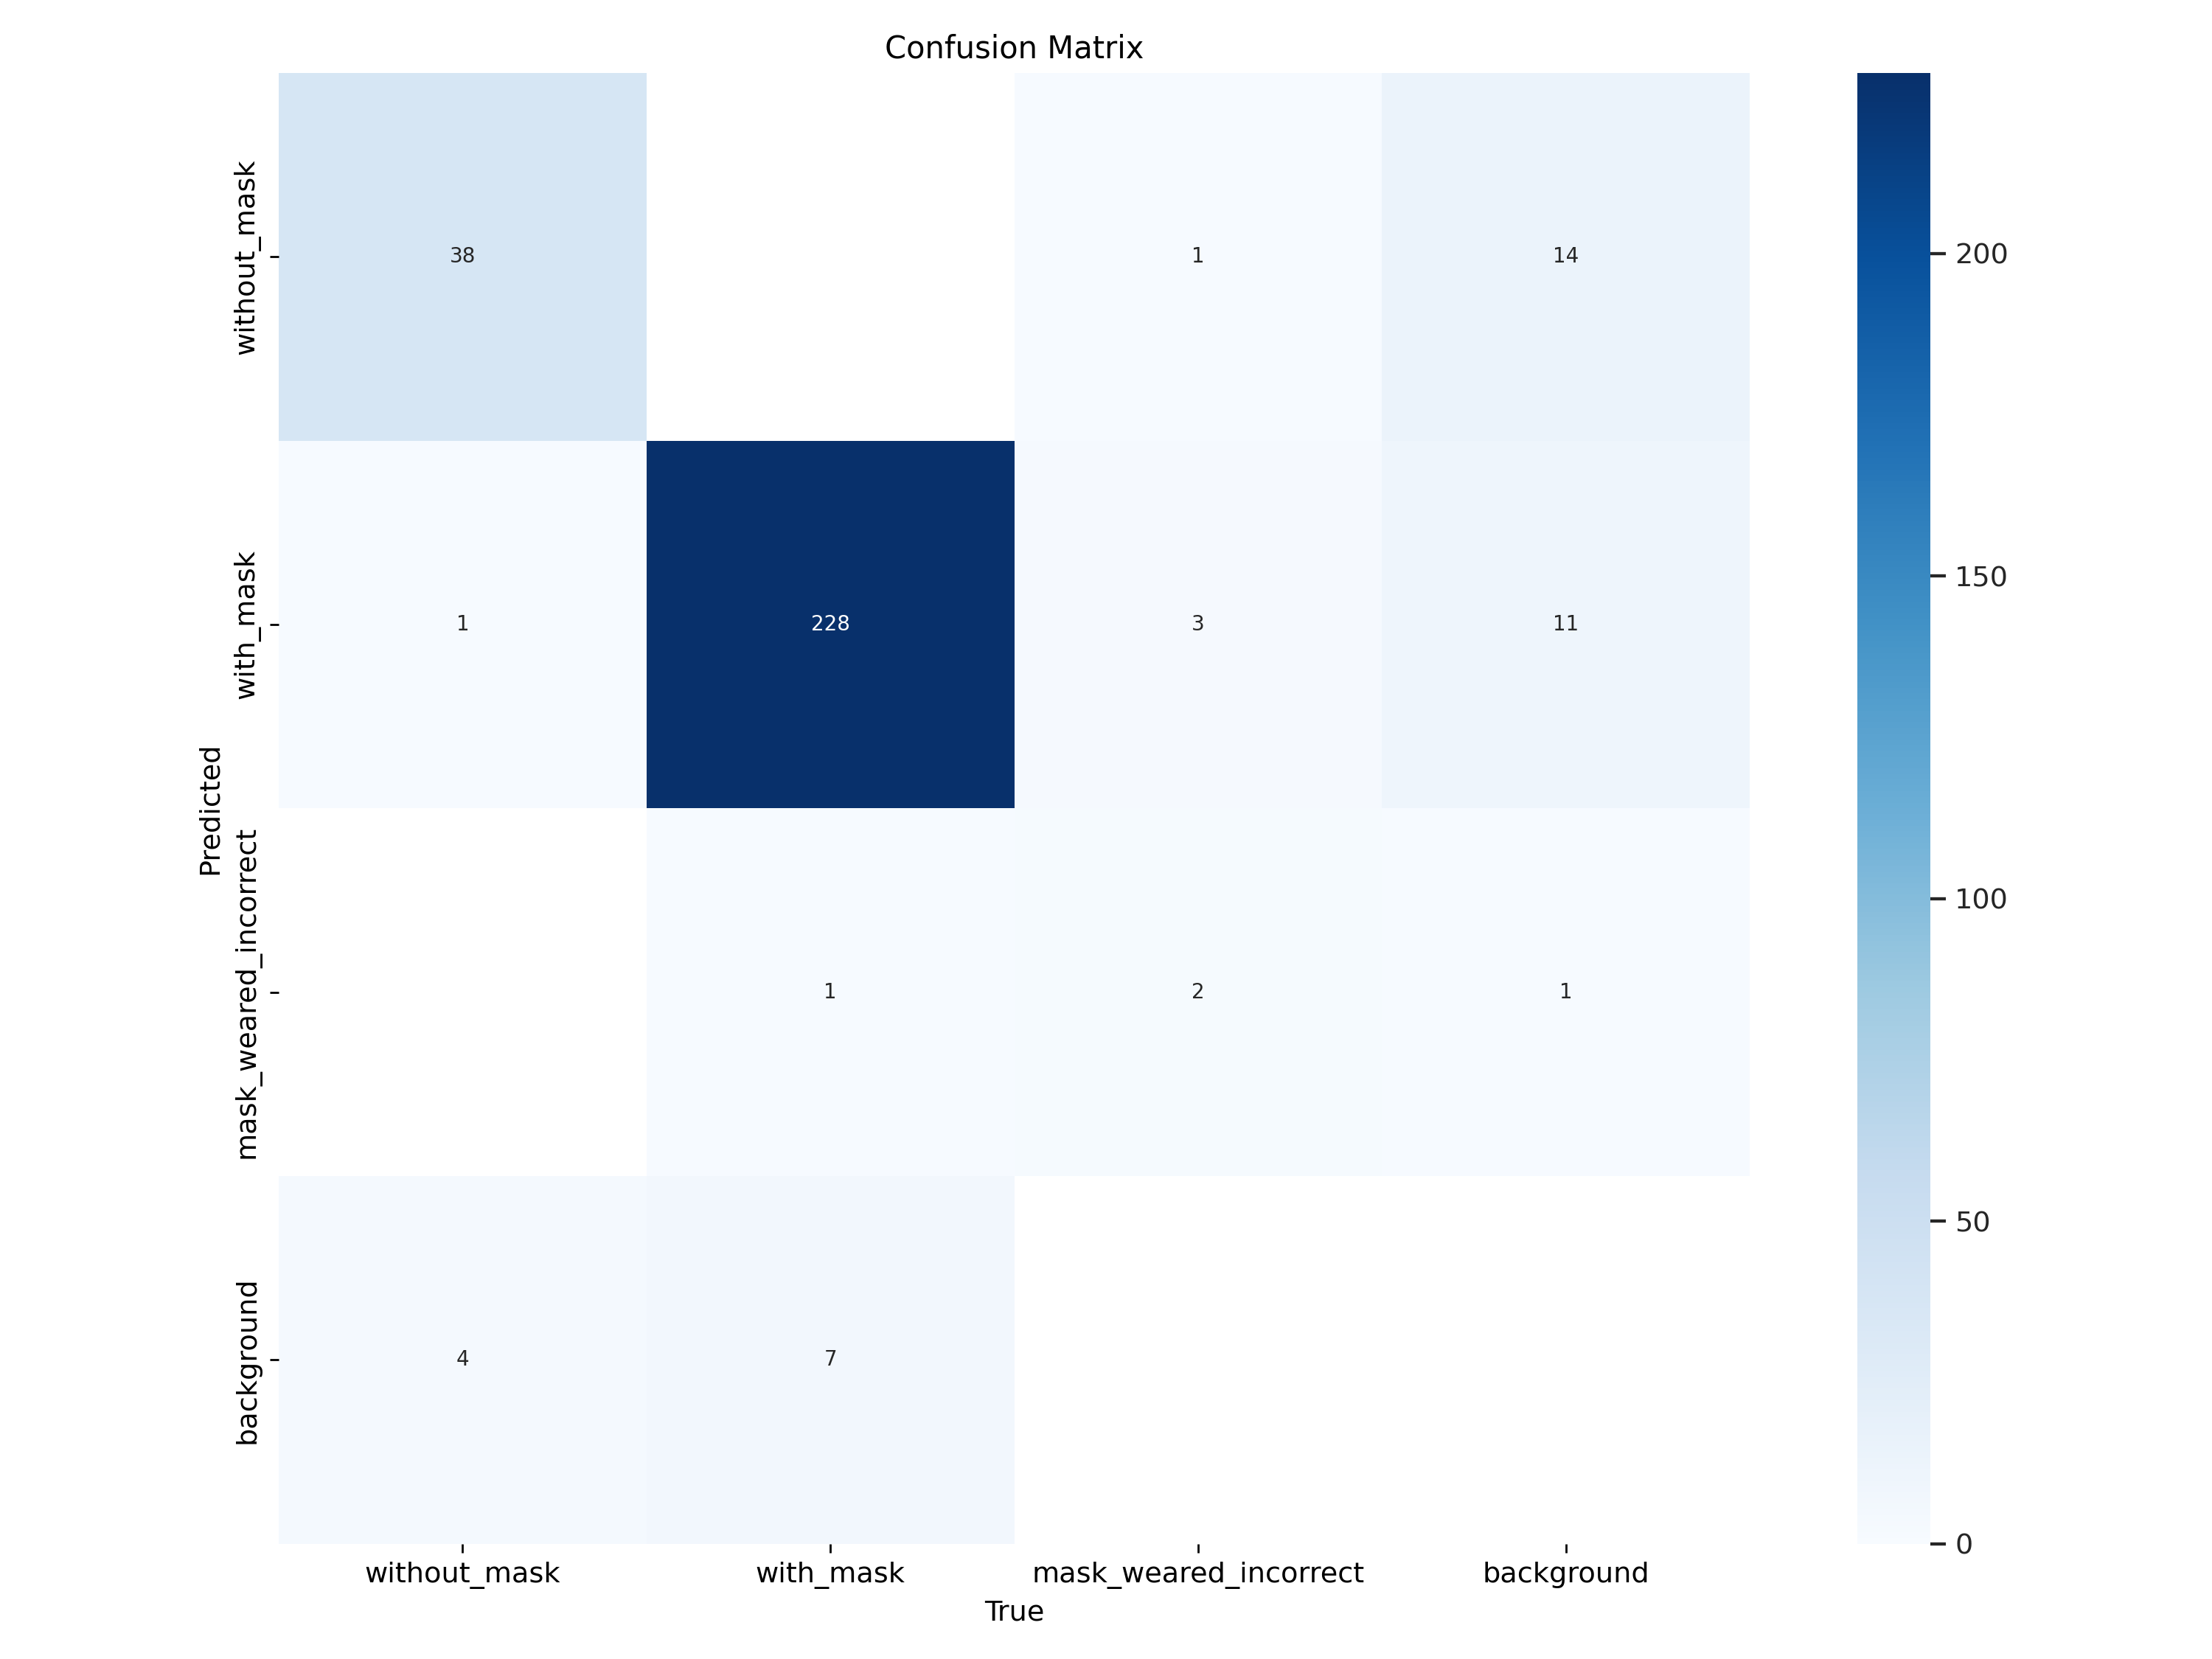

In [69]:
from google.colab import files

files.download('runs/detect/train/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Test

/content/dataset/val/images/maksssksksss32.png

0: 384x640 1 with_mask, 47.8ms
Speed: 2.5ms preprocess, 47.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


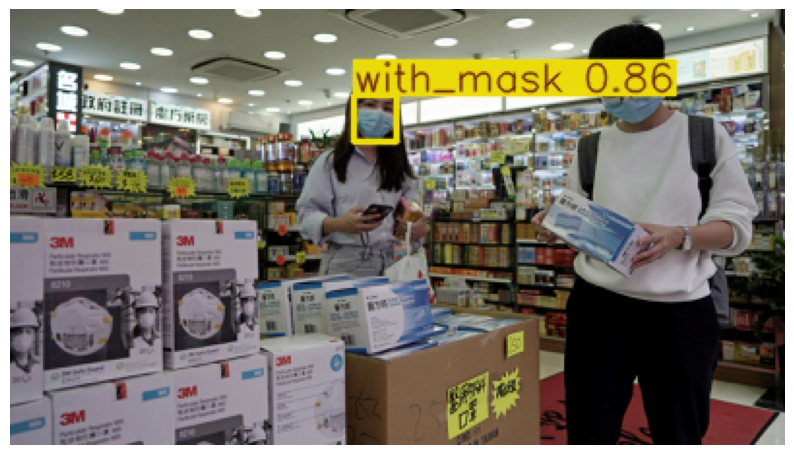

/content/dataset/val/images/maksssksksss102.png

0: 384x640 1 with_mask, 34.0ms
Speed: 2.3ms preprocess, 34.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


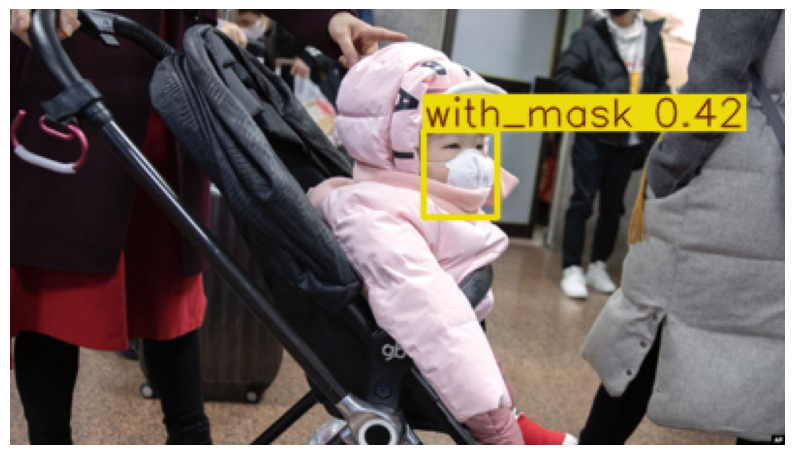

/content/dataset/val/images/maksssksksss405.png

0: 640x512 1 with_mask, 31.9ms
Speed: 2.9ms preprocess, 31.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


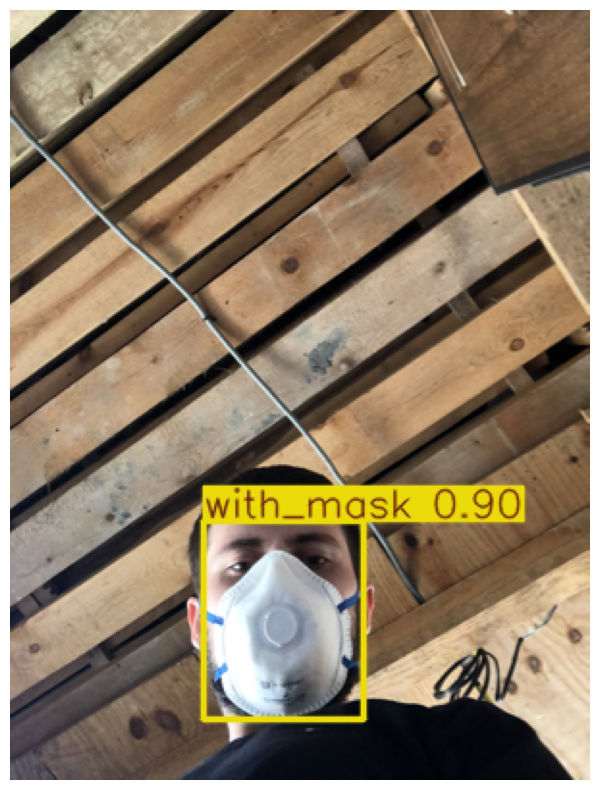

/content/dataset/val/images/maksssksksss666.png

0: 480x640 2 with_masks, 1 mask_weared_incorrect, 29.3ms
Speed: 2.7ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


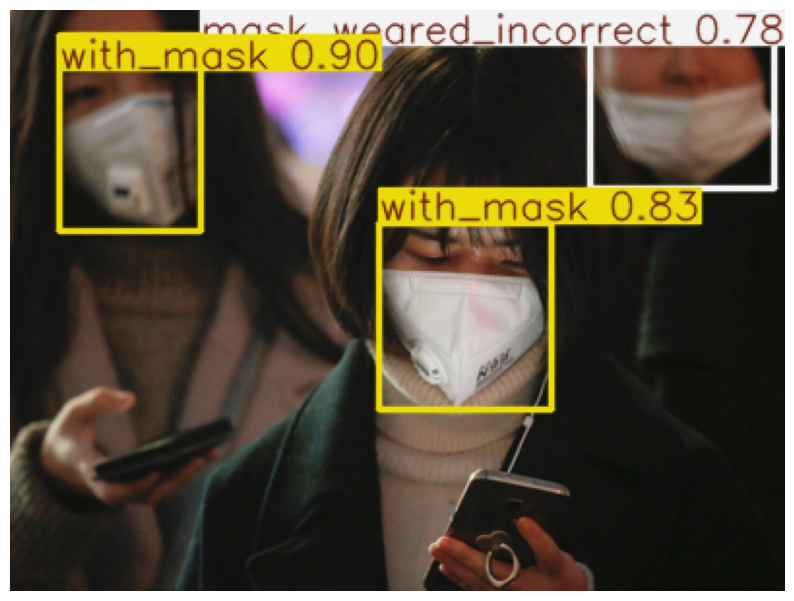

/content/dataset/val/images/maksssksksss759.png

0: 448x640 1 without_mask, 2 with_masks, 30.6ms
Speed: 2.6ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


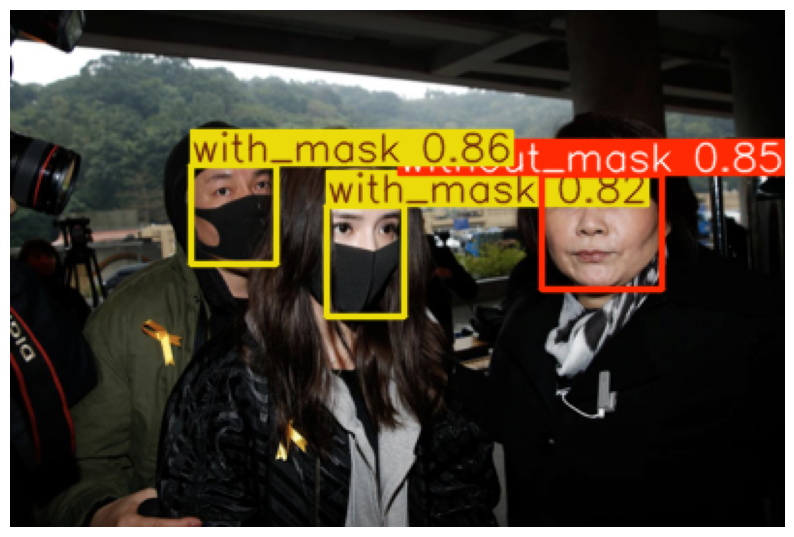

In [66]:
import cv2
from matplotlib import pyplot as plt
from PIL import Image

for img_ in os.listdir(val_path+'/images/')[37:42]:
    image_path = val_path + '/images/' + img_
    print(image_path)

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = model(img)

    plt.figure(figsize=(10, 10))
    plt.imshow(results[0].plot())
    plt.axis('off')
    plt.show()